# MadMiner tutorial 1: From cards to likelihood ratios (parton level)

Johann Brehmer, Felix Kling, Kyle Cranmer 2018

In this tutorial we'll introduce the basic MadMiner workflow, using parton-level samples with simple smearing functions. We'll show you how to use MadMiner to generate events, extract training data, and train neural networks to estimate likelihood ratios.

This tutorial does not try to explain the inference methods. To understand what MadMiner is doing, please have a look at some papers first. In
["Constraining Effective Field Theories With Machine Learning"](https://arxiv.org/abs/1805.00013)
we explain the basic idea of most of the methods presented here, while ["A Guide to Constraining Effective Field Theories With Machine Learning"](https://arxiv.org/abs/1805.00020) is an extensive 65-page handbook going through the details.

## Preparations

Before you execute this notebook, make sure you have running installations of MadGraph, Pythia, and Delphes.

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import logging
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

from madminer.core import MadMiner
from madminer.lhe import LHEReader
from madminer.sampling import combine_and_shuffle
from madminer.sampling import SampleAugmenter
from madminer import sampling
from madminer.ml import ParameterizedRatioEstimator
from madminer.plotting import plot_2d_morphing_basis, plot_distributions
from madminer.limits import AsymptoticLimits


Please enter here the path to your MG5 root directory.

In [2]:
mg_dir = '/Users/johannbrehmer/work/projects/madminer/MG5_aMC_v2_6_2'

MadMiner uses the Python `logging` module to provide additional information and debugging output. You can choose how much of this output you want to see by switching the level in the following lines to `logging.DEBUG` or `logging.WARNING`.

In [3]:
# MadMiner output
logging.basicConfig(
    format='%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s',
    datefmt='%H:%M',
    level=logging.DEBUG
)

# Output of all other modules (e.g. matplotlib)
for key in logging.Logger.manager.loggerDict:
    if "madminer" not in key:
        logging.getLogger(key).setLevel(logging.WARNING)

## Input data

As an example process, we'll simulate VBF Higgs production with a decay into two photons. We'll try to measure two EFT coefficients that affect this process.

Have a look at the `cards` folder. You'll find text files ("cards") that specify the process simulation in typical MadGraph convention.

## 1. Define parameter space

After creating a `MadMiner` instance, the first important step is the definition of the parameter space. Each model parameter is characterized by a name as well as the LHA block and ID.

If morphing is used, one also has to specify the maximal power with which the parameter contributes to the squared matrix element. For instance, a parameter that contributes only to one vertex, will typically have `morphing_max_power=2`, while a parameter that contributes to two vertices usually has `morphing_max_power=4`. Exceptions arise for instance when the interference effects between the SM and dimension-six operators are modelled, but the square of the dimension-six amplitude (subleading in 1/Lambda) is not taken into account, in which case `morphing_max_power=1`. The `parameter_range` argument defines the range of parameter values that are used for the automatic optimization of the morphing basis.

Finally, the parameter values theta used internally by MadMiner and the parameter values written to the param_card (or reweight_card) given to MadGraph do not have to be exactly the same. With the option `parm_card_transform`, the user can supply a one-parameter function that maps a parameter value theta to the value given to MadGraph. This string is a python expression, in which `theta` is parsed as the parameter value. For instance, if the internal parameters are in the range (0, 1), but should be linearly scaled to (0, 100) in the param_card, one would have to use `param_card_transform="100*theta"`.

In [4]:
miner = MadMiner()

miner.add_parameter(
    lha_block='dim6',
    lha_id=2,
    parameter_name='CWL2',
    morphing_max_power=2,
    param_card_transform="16.52*theta",
    parameter_range=(-10.,10.)
)
miner.add_parameter(
    lha_block='dim6',
    lha_id=5,
    parameter_name='CPWL2',
    morphing_max_power=2,
    param_card_transform="16.52*theta",
    parameter_range=(-10.,1.0)
)

11:01 madminer.core        INFO    Added parameter CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-10.0, 10.0))
11:01 madminer.core        INFO    Added parameter CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-10.0, 1.0))


## 2. Define benchmark points (evaluation points for |M|^2)

The next step is the definition of all the points at which the weights (squared matrix elements) should be evaluated by MadGraph. We call these points "benchmarks".

### Set benchmarks by hand

One can define benchmarks by hand:

In [ ]:
miner.add_benchmark(
    {'CWL2':0., 'CPWL2':0.},
    'sm'
)
miner.add_benchmark(
    {'CWL2':10., 'CPWL2':0.},
    'w'
)

### Morphing setup

If morphing is used, the function `set_morphing` has to be called. With the option `include_existing_benchmarks=True`, MadMiner will keep all the benchmark points defined beforehand and run a simple optimization algorithm to fix the remaining ones for the basis (which may be none). Otherwise, MadMiner will optimize the full basis and forget about all previously defined benchmark points.

The other important keyword is `max_overall_power`. This sets the maximal combined power with which all parameters together contribute to the squared matrix element (cross section). This constraint is in addition to the `morphing_max_power` keyword of `add_parameter()` (see above). For instance, if there are two parameters of interest `a` and `b`, and it is known that there are contributions proportional to `1` (constant), `a`, `a^2`, `b`, `b^2`, and `ab`, then `max_overall_power=2`. If there are also contributions proportional to `a^2 b`, `a b^2`, and `a^2 b^2`, then `max_overall_power=4`.

In [ ]:
miner.set_morphing(
    include_existing_benchmarks=True,
    max_overall_power=2
)

Let's have a look at the resulting morphing basis and the "morphing error", i.e. the sum of squared morphing weights as a function of the parameter space. The black dots mark the benchmarks at which the squared matrix element will be evaluated when MadGraph is run. In between them, the morphing will interpolate. Since the morphing knows about the functional form of the amplitudes, there is only a small numerical uncertainty in this interpolation, we expect that the color in this plot is indicative of this uncertainty.

In [ ]:
fig = plot_2d_morphing_basis(
    miner.morpher,
    xlabel=r'$c_{W} v^2 / \Lambda^2$',
    ylabel=r'$c_{\tilde{W}} v^2 / \Lambda^2$',
    xrange=(-10.,10.),
    yrange=(-10.,10.)
)

The parameter space, benchmark points, and morphing setup are saved in a HDF5 file:

In [ ]:
miner.save('data/madminer_example.h5')

They can now be loaded again with `miner.load(filename)`.

## 3. Save settings and run MadGraph

In a next step, MadMiner starts MadGraph to generate events and calculate the weights. You have to provide paths to the process card, run card, param card (the entries corresponding to the parameters of interest will be automatically adapted), and an empty reweight card. Log files in the `log_directory` folder collect the MadGraph output and are important for debugging.

The `sample_benchmark` option can be used to specify which benchmark should be used for sampling. If it is not used, MadMiner will automatically use the benchmark that was added first.

Finally, if your default Python interpreter is 3.x, you will want to use `python2_override=True` to force MadGraph to be started with Python 2.x.

In [ ]:
miner.run(
    sample_benchmark='sm',
    mg_directory=mg_dir,
    mg_process_directory='./mg_processes/signal',
    proc_card_file='cards/proc_card_signal.dat',
    param_card_template_file='cards/param_card_template.dat',
    run_card_file='cards/run_card_signal.dat',
    log_directory='logs/signal',
    python2_override=True,
)

This will take a moment -- time for a coffee break!

After running any event generation through MadMiner, you should check whether the run succeeded: are the usual output files there (LHE and HepMC), do the log files show any error messages? MadMiner does not perform any explicit checks, and if something went wrong in the event generation, it will only notice later when trying to load the event files.

It is possible to start multiple processes based on the same `MadMiner` instance. This can be used to combine samples sampled according to different benchmarks, and to add reducible backgrounds. 

For the latter, a useful option is the `is_background` switch, which should be used for processes that do *not* depend on the parameters theta. `is_background=True` will disable the reweighting and re-use the same weights for all cross sections.

To reduce the runtime of the notebook, the background part is commented out here. Feel free to activate it and let it run during a lunch break.

In [ ]:
"""
miner.run(
    is_background=True,
    sample_benchmark='sm',
    mg_directory=mg_dir,
    mg_process_directory='./mg_processes/background',
    proc_card_file='cards/proc_card_background.dat',
    param_card_template_file='cards/param_card_template.dat',
    run_card_file='cards/run_card_background.dat',
    log_directory='logs/background',
)
"""

Finally, two options might be very useful for larger projects:
- `MadMiner.run_multiple()` allows you to start multiple runs with different run cards or different choices of `sample_benchmark`.
- Both `MadMiner.run()` and `MadMiner.run_multiple()` have a `only_create_script` keyword. If that is set to True, MadMiner will not start the event generation directly, but prepare folders with all the right settings and ready-to-run bash scripts. This might make it much easier to generate Events on a high-performance computing system. 

## 4. Run smearing and extract observables

The `madminer.lhe` submodule allows us to extract observables directly from the parton-level LHE samples, including an approximate description of the detector response with smearing functions. The central object is an instance of the `LHEProcessor` class, which has to be initialized with a MadMiner file:

In [ ]:
lhe = LHEReader('data/madminer_example.h5')

After creating the LHEProcessor object, one can add a number of event samples (the output of running MadGraph in step 3) with the `add_sample()` function.

In addition, you have to provide the information which sample was generated from which benchmark with the `sampled_from_benchmark` keyword, and set `is_background=True` for all background samples.

In [ ]:
lhe.add_sample(
    lhe_filename='mg_processes/signal/Events/run_01/unweighted_events.lhe.gz',
    sampled_from_benchmark='sm',
    is_background=False,
    k_factor=1.1,
)

"""
lhe.add_sample(
    lhe_filename='mg_processes/background/Events/run_01/unweighted_events.lhe.gz',
    sampled_from_benchmark='sm',
    is_background=True,
    k_factor=1.0,
"""


Now we have to define the smearing functions that are used (in lieu of a proper shower and detector simulation). Here we will assume a simple 10% uncertainty on the jet energy measurements and a $\pm 0.1$ smearing for jet $\eta$ and $\phi$. The transverse momenta of the jets are then derived from the smeared energy and the on-shell condition for the quarks (this is what `pt_resolution_abs=None` does). The photons from the Higgs are assumed to be measured perfectly (otherwise we'd have to call `set_smearing` another time with `pdgis=[22]`).

In [ ]:
lhe.set_smearing(
    pdgids=[1,2,3,4,5,6,9,22,-1,-2,-3,-4,-5,-6],   # Partons giving rise to jets
    energy_resolution_abs=0.,
    energy_resolution_rel=0.1,
    pt_resolution_abs=None,
    pt_resolution_rel=None,
    eta_resolution_abs=0.1,
    eta_resolution_rel=0.,
    phi_resolution_abs=0.1,
    phi_resolution_rel=0.,
)

The next step is the definition of observables, either through a Python function or an expression that can be evaluated. Here we demonstrate the latter, which is implemented in `add_observable()`. In the expression string, you can use the terms `j[i]`, `e[i]`, `mu[i]`, `a[i]`, `met`, where the indices `i` refer to a ordering by the transverse momentum. In addition, you can use `p[i]`, which denotes the `i`-th particle in the order given in the LHE sample (which is the order in which the final-state particles where defined in MadGraph).

All of these represent objects inheriting from scikit-hep [LorentzVectors](http://scikit-hep.org/api/math.html#vector-classes), see the link for a documentation of their properties. In addition, they have `charge` and `pdg_id` properties.

`add_observable()` has an optional keyword `required`. If `required=True`, we will only keep events where the observable can be parsed, i.e. all involved particles have been detected. If `required=False`, un-parseable observables will be filled with the value of another keyword `default`.

In a realistic project, you would want to add a large number of observables that capture all information in your events. Here we will just define two observables, the transverse momentum of the leading (= higher-pT) jet, and the azimuthal angle between the two leading jets.

In [ ]:
lhe.add_observable(
    'pt_j1',
    'j[0].pt',
    required=False,
    default=0.,
)
lhe.add_observable(
    'delta_phi_jj',
    'j[0].deltaphi(j[1]) * (-1. + 2.*float(j[0].eta > j[1].eta))',
    required=True,
)
lhe.add_observable(
    'met',
    'met.pt',
    required=True,
)

We can also add cuts, again in parse-able strings. In addition to the objects discussed above, they can contain the observables:

In [ ]:
lhe.add_cut('(a[0] + a[1]).m > 124.')
lhe.add_cut('(a[0] + a[1]).m < 126.')
lhe.add_cut('pt_j1 > 30.')

The function `analyse_samples` then calculates all observables from the LHE file(s) generated before, applies the smearing, and checks which events pass the cuts:

In [ ]:
lhe.analyse_samples()

The values of the observables and the weights are then saved in the HDF5 file. It is possible to overwrite the same file, or to leave the original file intact and save all the data into a new file as follows:

In [ ]:
lhe.save('data/madminer_example_with_data2.h5')

### A look at distributions

Let's see what our MC run produced:

In [ ]:
_ = plot_distributions(
    filename='data/madminer_example_with_data2.h5',
    parameter_points=['sm', np.array([10.,0.])],
    line_labels=['SM', 'BSM'],
    uncertainties='none',
    n_bins=20,
    n_cols=3,
    normalize=True,
)

## 5. Combine and shuffle different event samples

To reduce disk usage, you can generate several small event samples with the steps given above, and combine them now. Note that (for now) it is essential that all of them are generated with the same setup, including the same benchmark points / morphing basis!

In our case we only have one sample, so this is not strictly necessary, but we still include it for completeness.

In [ ]:
combine_and_shuffle(
    ['data/madminer_example_with_data.h5'],
    'data/madminer_example_shuffled.h5'
)

## 6. Make (unweighted) training and test samples with augmented data

At this point, we have all the information we need from MadGraph, Pythia, and Delphes. But the data is not quite ready to be used for machine learning. The `madminer.sampling` class `SampleAugmenter` will take care of the remaining book-keeping steps before we can train our estimators:

First, it unweights the samples, i.e. for a given parameter vector `theta` (or a distribution `p(theta)`) it picks events `x` such that their distribution follows `p(x|theta)`. The selected samples will all come from the event file we have so far, but their frequency is changed -- some events will appear multiple times, some will disappear.

Second, `SampleAugmenter` calculates all the augmented data ("gold") that is the key to our new inference methods. Depending on the specific technique, these are the joint likelihood ratio and / or the joint score. It saves all these pieces of information for the selected events in a set of numpy files that can easily be used in any machine learning framework.

In [5]:
sampler = SampleAugmenter('data/madminer_example_shuffled.h5')

16:41 madminer.sampling    INFO    Loading data from data/madminer_example_shuffled.h5
16:41 madminer.sampling    INFO    Found 2 parameters
16:41 madminer.sampling    DEBUG      CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-10.0, 10.0))
16:41 madminer.sampling    DEBUG      CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-10.0, 1.0))
16:41 madminer.sampling    INFO    Did not find nuisance parameters
16:41 madminer.sampling    INFO    Found 6 benchmarks, of which 6 physical
16:41 madminer.sampling    DEBUG      sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:41 madminer.sampling    DEBUG      w: CWL2 = 10.00, CPWL2 = 0.00e+00
16:41 madminer.sampling    DEBUG      morphing_basis_vector_2: CWL2 = -2.43e+00, CPWL2 = -9.92e+00
16:41 madminer.sampling    DEBUG      morphing_basis_vector_3: CWL2 = -8.02e+00, CPWL2 = -5.62e+00
16:41 madminer.sampling    DEBUG      morphing_basis_vector_4: CWL2 = -7.13e+00, CPWL2 = -1.36e+00
16:41 madminer.sampling    DEBUG      morph

The `SampleAugmenter` class defines five different high-level functions to generate train or test samples:
- `extract_samples_train_plain()`, which only saves observations x, for instance for histograms or ABC;
- `extract_samples_train_local()` for methods like SALLY and SALLINO, which will be demonstrated in the second part of the tutorial;
- `extract_samples_train_ratio()` for techniques like CARL, ROLR, CASCAL, and RASCAL, when only theta0 is parameterized;
- `extract_samples_train_more_ratios()` for the same techniques, but with both theta0 and theta1 parameterized;
- `extract_samples_test()` for the evaluation of any method.

For the arguments `theta`, `theta0`, or `theta1`, you can (and should!) use the helper functions `constant_benchmark_theta()`, `multiple_benchmark_thetas()`, `constant_morphing_theta()`, `multiple_morphing_thetas()`, and `random_morphing_thetas()`, all defined in the `madminer.sampling` module.

Here we'll train a likelihood ratio estimator with the ALICES method, so we focus on the `extract_samples_train_ratio()` function.

In [6]:
x, theta0, theta1, y, r_xz, t_xz = sampler.extract_samples_train_ratio(
    theta0=sampling.random_morphing_points(100, [('gaussian', 0., 15.), ('gaussian', 0., 15.)]),
    theta1=sampling.benchmark('sm'),
    n_samples=100000,
    folder='./data/samples',
    filename='train'
)

16:41 madminer.sampling    INFO    Extracting training sample for ratio-based methods. Numerator hypothesis: ('random', (100, [('gaussian', 0.0, 15.0), ('gaussian', 0.0, 15.0)])), denominator hypothesis: ('benchmark', 'sm')
16:41 madminer.utils.analy DEBUG   Total n_samples: 50000, n_benchmarks_phys: 100, n_samples_per_theta: 500
16:41 madminer.sampling    DEBUG   Starting sample extraction
16:41 madminer.sampling    DEBUG   Augmented data requested:
16:41 madminer.sampling    DEBUG     ('ratio', 0, 1)
16:41 madminer.sampling    DEBUG     ('score', 0)
16:41 madminer.sampling    DEBUG   Benchmark cross sections [pb]: [5.96931280e-05 4.56876253e-04 8.56427145e-04 8.25995427e-04
 4.94205508e-04 3.81069381e-04]
16:41 madminer.sampling    DEBUG   Drawing 500 events for the following thetas:
16:41 madminer.sampling    DEBUG     theta 0 = [  7.53046865 -14.0097156 ] (sampling)
16:41 madminer.sampling    DEBUG     theta 1 = [0. 0.]
16:41 madminer.sampling    WARNING Large statistical uncertain

16:41 madminer.sampling    DEBUG     Cumulative probability (should be close to 1): 1.0000000000000169
16:41 madminer.sampling    DEBUG   Drawing 500 events for the following thetas:
16:41 madminer.sampling    DEBUG     theta 0 = [ -3.80102749 -17.00069245] (sampling)
16:41 madminer.sampling    DEBUG     theta 1 = [0. 0.]
16:41 madminer.sampling    DEBUG     Cumulative probability (should be close to 1): 1.0000000000000049
16:41 madminer.sampling    DEBUG   Drawing 500 events for the following thetas:
16:41 madminer.sampling    DEBUG     theta 0 = [12.89455628  0.89313802] (sampling)
16:41 madminer.sampling    DEBUG     theta 1 = [0. 0.]
16:41 madminer.sampling    DEBUG     Cumulative probability (should be close to 1): 1.000000000000005
16:41 madminer.sampling    DEBUG   Drawing 500 events for the following thetas:
16:41 madminer.sampling    DEBUG     theta 0 = [ -3.65111221 -15.59384946] (sampling)
16:41 madminer.sampling    DEBUG     theta 1 = [0. 0.]
16:41 madminer.sampling    DEBU

16:41 madminer.sampling    DEBUG   Drawing 500 events for the following thetas:
16:41 madminer.sampling    DEBUG     theta 0 = [ -2.60837436 -12.52063416] (sampling)
16:41 madminer.sampling    DEBUG     theta 1 = [0. 0.]
16:41 madminer.sampling    DEBUG     Cumulative probability (should be close to 1): 1.0000000000000036
16:41 madminer.sampling    DEBUG   Drawing 500 events for the following thetas:
16:41 madminer.sampling    DEBUG     theta 0 = [ 14.16142818 -10.16012825] (sampling)
16:41 madminer.sampling    DEBUG     theta 1 = [0. 0.]
16:41 madminer.sampling    DEBUG     Cumulative probability (should be close to 1): 1.000000000000019
16:41 madminer.sampling    DEBUG   Drawing 500 events for the following thetas:
16:41 madminer.sampling    DEBUG     theta 0 = [ 6.29939726 -9.52519256] (sampling)
16:41 madminer.sampling    DEBUG     theta 1 = [0. 0.]
16:41 madminer.sampling    DEBUG     Cumulative probability (should be close to 1): 1.0000000000000102
16:41 madminer.sampling    DEBU

16:41 madminer.sampling    DEBUG     theta 0 = [-14.91185514  14.82510105] (sampling)
16:41 madminer.sampling    DEBUG     theta 1 = [0. 0.]
16:41 madminer.sampling    DEBUG     Cumulative probability (should be close to 1): 1.000000000000021
16:41 madminer.sampling    DEBUG   Drawing 500 events for the following thetas:
16:41 madminer.sampling    DEBUG     theta 0 = [-0.97408124  1.51889741] (sampling)
16:41 madminer.sampling    DEBUG     theta 1 = [0. 0.]
16:41 madminer.sampling    DEBUG     Cumulative probability (should be close to 1): 0.9999999999999288
16:41 madminer.sampling    DEBUG   Drawing 500 events for the following thetas:
16:41 madminer.sampling    DEBUG     theta 0 = [-15.72678487  -6.39232936] (sampling)
16:41 madminer.sampling    DEBUG     theta 1 = [0. 0.]
16:41 madminer.sampling    DEBUG     Cumulative probability (should be close to 1): 1.0000000000000049
16:41 madminer.sampling    DEBUG   Drawing 500 events for the following thetas:
16:41 madminer.sampling    DEBU

16:41 madminer.sampling    DEBUG   Drawing 500 events for the following thetas:
16:41 madminer.sampling    DEBUG     theta 0 = [-26.40737104   0.48202231] (sampling)
16:41 madminer.sampling    DEBUG     theta 1 = [0. 0.]
16:41 madminer.sampling    DEBUG     Cumulative probability (should be close to 1): 1.000000000000017
16:41 madminer.sampling    DEBUG   Drawing 500 events for the following thetas:
16:41 madminer.sampling    DEBUG     theta 0 = [-1.29041901 12.65242845] (sampling)
16:41 madminer.sampling    DEBUG     theta 1 = [0. 0.]
16:41 madminer.sampling    DEBUG     Cumulative probability (should be close to 1): 1.0000000000000098
16:41 madminer.sampling    INFO    Effective number of samples: mean 21.021208964224094, with individual thetas ranging from 6.422351073958503 to 465.70132078958045
16:41 madminer.sampling    DEBUG   Effective number of samples for all thetas: [ 27.4438546   18.0372454    9.97650447  21.70957366  11.0096493
   9.39278851  36.06595099  19.43489839  16.81

16:41 madminer.sampling    DEBUG     theta 0 = [12.64681232  2.16160512]
16:41 madminer.sampling    DEBUG     theta 1 = [0. 0.] (sampling)
16:41 madminer.sampling    DEBUG     Cumulative probability (should be close to 1): 0.999999999999793
16:41 madminer.sampling    DEBUG   Drawing 500 events for the following thetas:
16:41 madminer.sampling    DEBUG     theta 0 = [-26.45113735   7.8079628 ]
16:41 madminer.sampling    DEBUG     theta 1 = [0. 0.] (sampling)
16:41 madminer.sampling    DEBUG     Cumulative probability (should be close to 1): 0.999999999999793
16:41 madminer.sampling    DEBUG   Drawing 500 events for the following thetas:
16:41 madminer.sampling    DEBUG     theta 0 = [-12.48475983   5.34055297]
16:41 madminer.sampling    DEBUG     theta 1 = [0. 0.] (sampling)
16:41 madminer.sampling    DEBUG     Cumulative probability (should be close to 1): 0.999999999999793
16:41 madminer.sampling    DEBUG   Drawing 500 events for the following thetas:
16:41 madminer.sampling    DEBUG 

16:41 madminer.sampling    DEBUG   Drawing 500 events for the following thetas:
16:41 madminer.sampling    DEBUG     theta 0 = [ 4.51558043 10.44182045]
16:41 madminer.sampling    DEBUG     theta 1 = [0. 0.] (sampling)
16:41 madminer.sampling    DEBUG     Cumulative probability (should be close to 1): 0.999999999999793
16:41 madminer.sampling    DEBUG   Drawing 500 events for the following thetas:
16:41 madminer.sampling    DEBUG     theta 0 = [ 5.21263111 12.5451961 ]
16:41 madminer.sampling    DEBUG     theta 1 = [0. 0.] (sampling)
16:41 madminer.sampling    DEBUG     Cumulative probability (should be close to 1): 0.999999999999793
16:41 madminer.sampling    DEBUG   Drawing 500 events for the following thetas:
16:41 madminer.sampling    DEBUG     theta 0 = [17.72292814  2.91982104]
16:41 madminer.sampling    DEBUG     theta 1 = [0. 0.] (sampling)
16:41 madminer.sampling    DEBUG     Cumulative probability (should be close to 1): 0.999999999999793
16:41 madminer.sampling    DEBUG   Dr

16:41 madminer.sampling    DEBUG     theta 1 = [0. 0.] (sampling)
16:41 madminer.sampling    DEBUG     Cumulative probability (should be close to 1): 0.999999999999793
16:41 madminer.sampling    DEBUG   Drawing 500 events for the following thetas:
16:41 madminer.sampling    DEBUG     theta 0 = [-18.97968442   9.58341799]
16:41 madminer.sampling    DEBUG     theta 1 = [0. 0.] (sampling)
16:41 madminer.sampling    DEBUG     Cumulative probability (should be close to 1): 0.999999999999793
16:41 madminer.sampling    DEBUG   Drawing 500 events for the following thetas:
16:41 madminer.sampling    DEBUG     theta 0 = [-4.78479343 -5.64832428]
16:41 madminer.sampling    DEBUG     theta 1 = [0. 0.] (sampling)
16:41 madminer.sampling    DEBUG     Cumulative probability (should be close to 1): 0.999999999999793
16:41 madminer.sampling    DEBUG   Drawing 500 events for the following thetas:
16:41 madminer.sampling    DEBUG     theta 0 = [21.91531235  1.75423419]
16:41 madminer.sampling    DEBUG   

16:41 madminer.sampling    DEBUG   Drawing 500 events for the following thetas:
16:41 madminer.sampling    DEBUG     theta 0 = [-31.55759561  -0.84421353]
16:41 madminer.sampling    DEBUG     theta 1 = [0. 0.] (sampling)
16:41 madminer.sampling    DEBUG     Cumulative probability (should be close to 1): 0.999999999999793
16:41 madminer.sampling    DEBUG   Drawing 500 events for the following thetas:
16:41 madminer.sampling    DEBUG     theta 0 = [-18.26722341  10.17506995]
16:41 madminer.sampling    DEBUG     theta 1 = [0. 0.] (sampling)
16:41 madminer.sampling    DEBUG     Cumulative probability (should be close to 1): 0.999999999999793
16:41 madminer.sampling    DEBUG   Drawing 500 events for the following thetas:
16:41 madminer.sampling    DEBUG     theta 0 = [-11.37500435  19.94795598]
16:41 madminer.sampling    DEBUG     theta 1 = [0. 0.] (sampling)
16:41 madminer.sampling    DEBUG     Cumulative probability (should be close to 1): 0.999999999999793
16:41 madminer.sampling    DEBU

For the evaluation we'll need a test sample:

In [7]:
_ = sampler.extract_samples_test(
    theta=sampling.benchmark('sm'),
    n_samples=1000,
    folder='./data/samples',
    filename='test'
)

16:41 madminer.sampling    INFO    Extracting evaluation sample. Sampling according to ('benchmark', 'sm')
16:41 madminer.sampling    DEBUG   Starting sample extraction
16:41 madminer.sampling    DEBUG   Augmented data requested:
16:41 madminer.sampling    DEBUG   Benchmark cross sections [pb]: [1.49061616e-05 1.29651876e-04 2.21277528e-04 2.09581736e-04
 1.28291764e-04 1.11480390e-04]
16:41 madminer.sampling    DEBUG   Drawing 1000 events for the following thetas:
16:41 madminer.sampling    DEBUG     theta 0 = [0. 0.] (sampling)
16:41 madminer.sampling    DEBUG     Cumulative probability (should be close to 1): 1.000000000000043
16:41 madminer.sampling    INFO    Effective number of samples: 1305.9999999999793


### Plot cross section over parameter space

We can also calculate total cross sections:

In [8]:
thetas_benchmarks, xsecs_benchmarks, xsec_errors_benchmarks = sampler.extract_cross_sections(
    theta=sampling.benchmarks(['sm', 'w', 'morphing_basis_vector_2', 'morphing_basis_vector_3', 'morphing_basis_vector_4', 'morphing_basis_vector_5'])
)

thetas_morphing, xsecs_morphing, xsec_errors_morphing = sampler.extract_cross_sections(
    theta=sampling.random_morphing_points(1000, [('gaussian', 0., 4.), ('gaussian', 0., 4.)])
)

16:42 madminer.sampling    INFO    Starting cross-section calculation
16:42 madminer.sampling    DEBUG   theta [0. 0.]: xsec = (7.461070320001176e-05 +/- 9.228091471390091e-07) pb
16:42 madminer.sampling    DEBUG   theta [10.  0.]: xsec = (0.0005865335325157413 +/- 8.596214540753435e-05) pb
16:42 madminer.sampling    DEBUG   theta [-2.4302608  -9.92079124]: xsec = (0.0010777099565748597 +/- 8.049624778356755e-05) pb
16:42 madminer.sampling    DEBUG   theta [-8.02268504 -5.62121683]: xsec = (0.0010356129389476436 +/- 9.019747307439231e-05) pb
16:42 madminer.sampling    DEBUG   theta [-7.12856671 -1.35942063]: xsec = (0.0006225448128960891 +/- 5.087218583676365e-05) pb
16:42 madminer.sampling    DEBUG   theta [ 8.5233767  -3.16814617]: xsec = (0.0004925564068011558 +/- 6.548148090699506e-05) pb
16:42 madminer.sampling    INFO    Starting cross-section calculation
16:42 madminer.utils.analy DEBUG   Total n_samples: 1, n_benchmarks_phys: 1000, n_samples_per_theta: 0
16:42 madminer.sampling

16:42 madminer.sampling    DEBUG   theta [-3.58931364  1.30852545]: xsec = (0.0002568858180402706 +/- 0.00010619931786171863) pb
16:42 madminer.sampling    DEBUG   theta [3.11980298 0.02078512]: xsec = (7.817376328123482e-05 +/- 2.1636077164448812e-05) pb
16:42 madminer.sampling    DEBUG   theta [-6.49853023 -2.33508739]: xsec = (0.0005834255020142378 +/- 4.5239826752514544e-05) pb
16:42 madminer.sampling    DEBUG   theta [2.47251772 0.95303804]: xsec = (7.491424629459532e-05 +/- 4.133640613767487e-05) pb
16:42 madminer.sampling    DEBUG   theta [ 2.43329726 -2.54858623]: xsec = (0.00012092071074712218 +/- 7.835101655865241e-05) pb
16:42 madminer.sampling    DEBUG   theta [-4.01637151 -5.49797693]: xsec = (0.0005695365508907988 +/- 9.569879000397419e-05) pb
16:42 madminer.sampling    DEBUG   theta [2.87304879 1.92591427]: xsec = (0.0001085652172408492 +/- 9.101604719083041e-05) pb
16:42 madminer.sampling    DEBUG   theta [-8.01872569 -1.44920234]: xsec = (0.0007435496822235458 +/- 6.27

16:42 madminer.sampling    DEBUG   theta [-0.17561735 -1.26542845]: xsec = (9.405055169894259e-05 +/- 4.621564753721473e-05) pb
16:42 madminer.sampling    DEBUG   theta [-5.04733685  2.61798057]: xsec = (0.0004191511616920241 +/- 0.00022106193096029373) pb
16:42 madminer.sampling    DEBUG   theta [ 8.18999176 -4.12948112]: xsec = (0.0005180295870051298 +/- 8.01309175014353e-05) pb
16:42 madminer.sampling    DEBUG   theta [-3.86322663 -2.58160083]: xsec = (0.00033526307788497796 +/- 6.35093556056338e-05) pb
16:42 madminer.sampling    DEBUG   theta [-4.19476092  1.89517881]: xsec = (0.0003183872976344627 +/- 0.00015336185761059614) pb
16:42 madminer.sampling    DEBUG   theta [-3.61982251  2.14786759]: xsec = (0.0002824124596361652 +/- 0.0001600251631778914) pb
16:42 madminer.sampling    DEBUG   theta [ 6.44142103 -5.61236309]: xsec = (0.0004986753967391158 +/- 9.689455231814059e-05) pb
16:42 madminer.sampling    DEBUG   theta [-4.01710792 -9.73864965]: xsec = (0.0011647530824645009 +/- 7

16:42 madminer.sampling    DEBUG   theta [ 2.18712175 -3.39595325]: xsec = (0.0001629053372823367 +/- 9.035746244279936e-05) pb
16:42 madminer.sampling    DEBUG   theta [3.65873889 4.27874359]: xsec = (0.00026553698377737177 +/- 0.00024795665995661314) pb
16:42 madminer.sampling    DEBUG   theta [-3.63504887 -1.90338231]: xsec = (0.0002879383616325082 +/- 4.8003719832417585e-05) pb
16:42 madminer.sampling    DEBUG   theta [ 2.14372749 -1.40525609]: xsec = (7.839394642767192e-05 +/- 5.407936360914598e-05) pb
16:42 madminer.sampling    DEBUG   theta [-7.80656437  0.84326682]: xsec = (0.0006875396321323841 +/- 0.0001630794322959362) pb
16:42 madminer.sampling    DEBUG   theta [-4.23292428 -1.9018712 ]: xsec = (0.00033581185487900026 +/- 4.4538433945165716e-05) pb
16:42 madminer.sampling    DEBUG   theta [ 0.87988326 -5.42995995]: xsec = (0.0003264112899372917 +/- 9.877202092209896e-05) pb
16:42 madminer.sampling    DEBUG   theta [ 1.23161056 11.3997469 ]: xsec = (0.001227665826870005 +/- 

16:42 madminer.sampling    DEBUG   theta [ 5.06052164 -2.1700478 ]: xsec = (0.00018781174983247272 +/- 6.261997662364632e-05) pb
16:42 madminer.sampling    DEBUG   theta [0.77253769 0.65987927]: xsec = (6.609473687489223e-05 +/- 2.7149005946263688e-05) pb
16:42 madminer.sampling    DEBUG   theta [2.35611965 2.43710212]: xsec = (0.00011985676063484005 +/- 0.00012094579173447918) pb
16:42 madminer.sampling    DEBUG   theta [ 1.5930274  -7.57115159]: xsec = (0.0005701238233822642 +/- 8.617755769114354e-05) pb
16:42 madminer.sampling    DEBUG   theta [-1.59781961 -0.207767  ]: xsec = (0.00012842082346168 +/- 1.0874417882664645e-05) pb
16:42 madminer.sampling    DEBUG   theta [ 3.48870535 -8.15842459]: xsec = (0.0006710395646878525 +/- 0.0001083434192339203) pb
16:42 madminer.sampling    DEBUG   theta [ 2.21226518 13.00457128]: xsec = (0.001592006922769936 +/- 0.001306967777033743) pb
16:42 madminer.sampling    DEBUG   theta [0.51084598 2.13712554]: xsec = (0.00010575906164872728 +/- 0.0001

16:42 madminer.sampling    DEBUG   theta [-8.02608561  5.85045257]: xsec = (0.0009862846817839058 +/- 0.0006016160321066381) pb
16:42 madminer.sampling    DEBUG   theta [-1.29828032 -0.61790337]: xsec = (0.00011931135479306058 +/- 1.9614288416277507e-05) pb
16:42 madminer.sampling    DEBUG   theta [-3.32065341  5.14680754]: xsec = (0.0004485206882205112 +/- 0.00040057183672683453) pb
16:42 madminer.sampling    DEBUG   theta [-0.4340056  -0.09802785]: xsec = (8.552819870309621e-05 +/- 3.6388237145935813e-06) pb
16:42 madminer.sampling    DEBUG   theta [ 5.94493552 -0.22725288]: xsec = (0.00020320393976561147 +/- 3.822823937603673e-05) pb
16:42 madminer.sampling    DEBUG   theta [9.76433856 0.83830984]: xsec = (0.0005692502592027184 +/- 0.00010966156478155489) pb
16:42 madminer.sampling    DEBUG   theta [ 8.32233438 -3.81331026]: xsec = (0.0005097858982724291 +/- 7.523474693777135e-05) pb
16:42 madminer.sampling    DEBUG   theta [-0.48839047 -4.89447252]: xsec = (0.0003070998450697757 +/

16:42 madminer.sampling    DEBUG   theta [-0.223204   -1.26595962]: xsec = (9.527030871633299e-05 +/- 4.607110479640788e-05) pb
16:42 madminer.sampling    DEBUG   theta [-3.76405764 -0.5422867 ]: xsec = (0.0002633601849231574 +/- 2.5961941024808675e-05) pb
16:42 madminer.sampling    DEBUG   theta [ 2.766917  -2.0106651]: xsec = (0.00010440309946857247 +/- 6.758061908137549e-05) pb
16:42 madminer.sampling    DEBUG   theta [ 6.93715644 -2.66097112]: xsec = (0.0003274923391723259 +/- 6.105512436623827e-05) pb
16:42 madminer.sampling    DEBUG   theta [-3.88899018  0.18007788]: xsec = (0.0002682076562809119 +/- 5.173907862837069e-05) pb
16:42 madminer.sampling    DEBUG   theta [ 2.30617983 -0.78117997]: xsec = (6.831811751109422e-05 +/- 3.661289051615491e-05) pb
16:42 madminer.sampling    DEBUG   theta [ -1.38701217 -10.5895372 ]: xsec = (0.0011431579448333013 +/- 0.0001113832562815523) pb
16:42 madminer.sampling    DEBUG   theta [-0.64821746 -6.61564389]: xsec = (0.0004922853498901302 +/- 

16:42 madminer.sampling    DEBUG   theta [3.87779851 4.11076149]: xsec = (0.0002604940790521263 +/- 0.0002351324083794239) pb
16:42 madminer.sampling    DEBUG   theta [ 7.59455101 -0.13021891]: xsec = (0.00033001245634244416 +/- 5.278200070605742e-05) pb
16:42 madminer.sampling    DEBUG   theta [-3.56151758 -2.90697442]: xsec = (0.00032898784574788355 +/- 7.23588129540967e-05) pb
16:42 madminer.sampling    DEBUG   theta [-0.0542849  1.0480772]: xsec = (8.488387518895205e-05 +/- 5.036684553497795e-05) pb
16:42 madminer.sampling    DEBUG   theta [3.18743451 1.68571489]: xsec = (0.00010791551594619802 +/- 7.876742067341941e-05) pb
16:42 madminer.sampling    DEBUG   theta [ 5.84084746 -2.59611063]: xsec = (0.0002484411325431083 +/- 6.521807484085283e-05) pb
16:42 madminer.sampling    DEBUG   theta [-4.8691631 -0.6966948]: xsec = (0.0003594009082077231 +/- 3.532364196493736e-05) pb
16:42 madminer.sampling    DEBUG   theta [-2.51124448  1.71775969]: xsec = (0.00019687939327930914 +/- 0.00011

16:42 madminer.sampling    DEBUG   theta [-5.44992388 -3.97845387]: xsec = (0.0005685670374411268 +/- 7.940337382089577e-05) pb
16:42 madminer.sampling    DEBUG   theta [-2.96126464 -3.86232447]: xsec = (0.0003470547111963632 +/- 9.052860960259014e-05) pb
16:42 madminer.sampling    DEBUG   theta [ 2.79676848 -6.99055741]: xsec = (0.0005009843032672526 +/- 9.20671182135512e-05) pb
16:42 madminer.sampling    DEBUG   theta [ 2.87733263 -3.21324537]: xsec = (0.00016119220607992547 +/- 8.63905542189429e-05) pb
16:42 madminer.sampling    DEBUG   theta [6.52798299 4.05652359]: xsec = (0.00040752659381157333 +/- 0.00024216784406985663) pb
16:42 madminer.sampling    DEBUG   theta [0.24707535 9.59670904]: xsec = (0.0008914361968009928 +/- 0.000839775395601379) pb
16:42 madminer.sampling    DEBUG   theta [ 7.31713378 -5.5157334 ]: xsec = (0.0005547470963351344 +/- 0.00010012907088548981) pb
16:42 madminer.sampling    DEBUG   theta [-4.68878227 -3.1117826 ]: xsec = (0.00043518985275774343 +/- 6.94

16:42 madminer.sampling    DEBUG   theta [-9.21843583  5.67494311]: xsec = (0.001139775084955645 +/- 0.000623049587802538) pb
16:42 madminer.sampling    DEBUG   theta [-2.79927431  6.58450882]: xsec = (0.0005635082628468956 +/- 0.0005369762996261065) pb
16:42 madminer.sampling    DEBUG   theta [ 4.40710901 -0.93836681]: xsec = (0.00012650832673494412 +/- 4.103880855790841e-05) pb
16:42 madminer.sampling    DEBUG   theta [-1.70889531  4.53756952]: xsec = (0.0003088575051929032 +/- 0.00031441220315728003) pb
16:42 madminer.sampling    DEBUG   theta [-1.84425813  0.76869241]: xsec = (0.00014289466561763888 +/- 5.2207813481785036e-05) pb
16:42 madminer.sampling    DEBUG   theta [-6.11696339  2.03291453]: xsec = (0.000505648603077254 +/- 0.0002020762480431177) pb
16:42 madminer.sampling    DEBUG   theta [-5.80228271 -4.0374177 ]: xsec = (0.0006105379427102984 +/- 7.833814927459168e-05) pb
16:42 madminer.sampling    DEBUG   theta [2.83235814 2.55552196]: xsec = (0.00013384908429420807 +/- 0.

16:42 madminer.sampling    DEBUG   theta [-2.10445622  3.03054092]: xsec = (0.00022801348168063624 +/- 0.00019823976903138882) pb
16:42 madminer.sampling    DEBUG   theta [2.7417316  8.20348189]: xsec = (0.0006844956027107787 +/- 0.0006317816123687694) pb
16:42 madminer.sampling    DEBUG   theta [-1.91908467 -5.06232213]: xsec = (0.00038333930196216 +/- 0.00010003066207235725) pb
16:42 madminer.sampling    DEBUG   theta [0.9785425  3.32021784]: xsec = (0.00015939836023958365 +/- 0.00018578155446566212) pb
16:42 madminer.sampling    DEBUG   theta [-0.89688613  0.39869997]: xsec = (0.00010070077224335819 +/- 2.4418132526342035e-05) pb
16:42 madminer.sampling    DEBUG   theta [-0.60790564 -2.56568131]: xsec = (0.00015242766666174323 +/- 7.831371966742126e-05) pb
16:42 madminer.sampling    DEBUG   theta [ 0.05032034 -2.10630132]: xsec = (0.00011478562489112534 +/- 6.981747400226696e-05) pb
16:42 madminer.sampling    DEBUG   theta [7.3787686  1.64968948]: xsec = (0.0003435172680162276 +/- 0

16:42 madminer.sampling    DEBUG   theta [ 5.52192876 -9.00344969]: xsec = (0.0008762022783635208 +/- 0.00017139631129863304) pb
16:42 madminer.sampling    DEBUG   theta [ 0.35944143 -3.63939148]: xsec = (0.00018835049699588374 +/- 9.519389484053272e-05) pb
16:42 madminer.sampling    DEBUG   theta [ 3.85769655 -2.26690747]: xsec = (0.0001412173641237968 +/- 6.927943644263129e-05) pb
16:42 madminer.sampling    DEBUG   theta [-0.61453948  2.15182427]: xsec = (0.0001297250551948556 +/- 0.00011920738105459516) pb
16:42 madminer.sampling    DEBUG   theta [ 1.63179896 -0.11410917]: xsec = (5.885390740682294e-05 +/- 1.4643693645736776e-05) pb
16:42 madminer.sampling    DEBUG   theta [-6.55325291  7.34083926]: xsec = (0.0009729077066429185 +/- 0.0007269735908202648) pb
16:42 madminer.sampling    DEBUG   theta [8.46796881 2.60825086]: xsec = (0.0004886103900543649 +/- 0.00017208360935258633) pb
16:42 madminer.sampling    DEBUG   theta [-0.87599949  4.91286163]: xsec = (0.000309250531225816 +/- 

16:42 madminer.sampling    DEBUG   theta [-0.36948622 -0.18787346]: xsec = (8.407248952416928e-05 +/- 6.604428280181756e-06) pb
16:42 madminer.sampling    DEBUG   theta [-0.11955458  0.39329794]: xsec = (7.837092063924256e-05 +/- 1.826595312532642e-05) pb
16:42 madminer.sampling    DEBUG   theta [ 1.47878734 -0.21627681]: xsec = (5.8971559218195434e-05 +/- 1.6670374736268198e-05) pb
16:42 madminer.sampling    DEBUG   theta [ 4.53506662 -2.29082833]: xsec = (0.00016780136112612158 +/- 6.693984872819342e-05) pb
16:42 madminer.sampling    DEBUG   theta [-0.02162542  3.82562763]: xsec = (0.0002037102727087606 +/- 0.00023262466075861635) pb
16:42 madminer.sampling    DEBUG   theta [ 1.99349237 -0.6739163 ]: xsec = (6.412812090667101e-05 +/- 3.284069663436656e-05) pb
16:42 madminer.sampling    DEBUG   theta [1.67066959 5.19659542]: xsec = (0.0003038084118894048 +/- 0.00033243397046959323) pb
16:42 madminer.sampling    DEBUG   theta [-2.3005077  -0.08253259]: xsec = (0.0001629934075487946 +/-

16:42 madminer.sampling    DEBUG   theta [ 1.15776286 -8.68799264]: xsec = (0.000736032827972044 +/- 8.810796737349908e-05) pb
16:42 madminer.sampling    DEBUG   theta [-1.02157567  4.23396406]: xsec = (0.00025911605721951796 +/- 0.0002780059633847274) pb
16:42 madminer.sampling    DEBUG   theta [4.64206633 3.47871281]: xsec = (0.00024891681840050314 +/- 0.0001913635621484211) pb
16:42 madminer.sampling    DEBUG   theta [-0.34292875  1.01234321]: xsec = (9.11023247376836e-05 +/- 5.0489686112698676e-05) pb
16:42 madminer.sampling    DEBUG   theta [-0.75961034 -1.38844184]: xsec = (0.00011422922217937277 +/- 4.7902980486543325e-05) pb
16:42 madminer.sampling    DEBUG   theta [-1.02986039  2.34064943]: xsec = (0.00015036285553501265 +/- 0.00013580325567407185) pb
16:42 madminer.sampling    DEBUG   theta [ 0.0404975  -2.88370845]: xsec = (0.00015035902371097397 +/- 8.526272414273164e-05) pb
16:42 madminer.sampling    DEBUG   theta [-1.65367402  7.34760249]: xsec = (0.0006010426815067863 +/

16:42 madminer.sampling    DEBUG   theta [ 0.6846077  -4.47717152]: xsec = (0.0002441991403485908 +/- 9.995612356497226e-05) pb
16:42 madminer.sampling    DEBUG   theta [-5.16687565  2.65404859]: xsec = (0.0004319411211720697 +/- 0.00022632183214329077) pb
16:42 madminer.sampling    DEBUG   theta [-2.66630119  6.01267101]: xsec = (0.0004927882060947457 +/- 0.00047332952265644236) pb
16:42 madminer.sampling    DEBUG   theta [-3.39543763 -7.98406376]: xsec = (0.0008288860852747458 +/- 7.56036425895083e-05) pb
16:42 madminer.sampling    DEBUG   theta [-2.20613147 -2.5837366 ]: xsec = (0.00022340945735271743 +/- 7.287312235356333e-05) pb
16:42 madminer.sampling    DEBUG   theta [ 0.83061999 -4.31748359]: xsec = (0.00022956893364705196 +/- 9.929285706627574e-05) pb
16:42 madminer.sampling    DEBUG   theta [-4.51009772 -1.057947  ]: xsec = (0.0003340757893479356 +/- 2.838685418015873e-05) pb
16:42 madminer.sampling    DEBUG   theta [1.89730048 2.06080828]: xsec = (9.932460355724783e-05 +/- 9

16:42 madminer.sampling    DEBUG   theta [ 1.88931988 -4.50670713]: xsec = (0.0002393135477753848 +/- 9.78516212760645e-05) pb
16:42 madminer.sampling    DEBUG   theta [ 2.30979988 -2.83438197]: xsec = (0.00013309065127741024 +/- 8.31063267877659e-05) pb
16:42 madminer.sampling    DEBUG   theta [-4.48918339  4.24496297]: xsec = (0.00046333090433159883 +/- 0.0003423562081101773) pb
16:42 madminer.sampling    DEBUG   theta [ 4.20072241 -5.86699885]: xsec = (0.00040808390261963724 +/- 9.395068669615684e-05) pb
16:42 madminer.sampling    DEBUG   theta [ 0.476413  -4.5223634]: xsec = (0.0002512601416350644 +/- 0.00010027370717754706) pb
16:42 madminer.sampling    DEBUG   theta [ 0.61613727 -3.67033459]: xsec = (0.00018601206170687783 +/- 9.539674877846362e-05) pb
16:42 madminer.sampling    DEBUG   theta [6.03340306 4.8522114 ]: xsec = (0.0004380490043758631 +/- 0.0002986614114873943) pb
16:42 madminer.sampling    DEBUG   theta [-0.21471332  0.03850272]: xsec = (7.955763517046397e-05 +/- 3.2

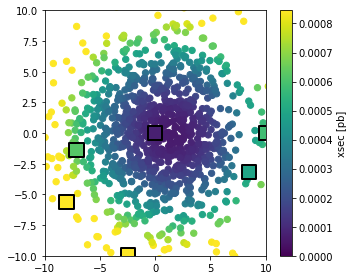

In [9]:
cmin, cmax = 0., 2.5 * np.mean(xsecs_morphing)

fig = plt.figure(figsize=(5,4))

sc = plt.scatter(thetas_morphing[:,0], thetas_morphing[:,1], c=xsecs_morphing,
            s=40., cmap='viridis', vmin=cmin, vmax=cmax,
            marker='o')

plt.scatter(thetas_benchmarks[:,0], thetas_benchmarks[:,1], c=xsecs_benchmarks,
            s=200., cmap='viridis', vmin=cmin, vmax=cmax, lw=2., edgecolor='black',
            marker='s')

cb = plt.colorbar(sc)
cb.set_label('xsec [pb]')

plt.xlim(-10.,10.)
plt.ylim(-10.,10.)
plt.tight_layout()
plt.show()

What  you see here is a morphing algorithm in action. We only asked MadGraph to calculate event weights (differential cross sections, or basically squared matrix elements) at six fixed parameter points (shown here as squares with black edges). But with our knowledge about the structure of the process we can interpolate any observable to any parameter point without loss (except that statistical uncertainties might increase)!

## 7. Train neural networks to estimate likelihood ratios

It's now time to build the neural network that estimates the likelihood ratio. The central object for this is the `madminer.ml.ParameterizedRatioEstimator` class. It defines functions that train, save, load, and evaluate the estimators.

In the initialization, the keywords `n_hidden` and `activation` define the architecture of the (fully connected) neural network:

In [10]:
estimator = ParameterizedRatioEstimator(
    n_hidden=(100,),
    activation="tanh"
)

### Training

To train this model we will minimize the ALICES loss function described in ["Likelihood-free inference with an improved cross-entropy estimator"](https://arxiv.org/abs/1808.00973). Many alternatives, including RASCAL, are described in ["Constraining Effective Field Theories With Machine Learning"](https://arxiv.org/abs/1805.00013) and ["A Guide to Constraining Effective Field Theories With Machine Learning"](https://arxiv.org/abs/1805.00020). There is also SCANDAL introduced in ["Mining gold from implicit models to improve likelihood-free inference"](https://arxiv.org/abs/1805.12244).

In [11]:
estimator.train(
    method='alices',
    theta='data/samples/theta0_train.npy',
    x='data/samples/x_train.npy',
    y='data/samples/y_train.npy',
    r_xz='data/samples/r_xz_train.npy',
    t_xz='data/samples/t_xz_train.npy',
    alpha=1.,
    n_epochs=20,
)

estimator.save('models/alices')

16:42 madminer.ml          INFO    Starting training
16:42 madminer.ml          INFO      Method:                 alices
16:42 madminer.ml          INFO      alpha:                  1.0
16:42 madminer.ml          INFO      Batch size:             200
16:42 madminer.ml          INFO      Optimizer:              amsgrad
16:42 madminer.ml          INFO      Epochs:                 20
16:42 madminer.ml          INFO      Learning rate:          0.001 initially, decaying to 0.0001
16:42 madminer.ml          INFO      Validation split:       0.25
16:42 madminer.ml          INFO      Early stopping:         True
16:42 madminer.ml          INFO      Scale inputs:           True
16:42 madminer.ml          INFO      Shuffle labels          False
16:42 madminer.ml          INFO      Samples:                all
16:42 madminer.ml          INFO    Loading training data
16:42 madminer.ml          INFO    Found 100000 samples with 2 parameters and 2 observables
16:42 madminer.ml          INFO    Resca

16:47 madminer.utils.ml.tr DEBUG   Training epoch 18 / 20
16:47 madminer.utils.ml.tr DEBUG   Learning rate: 0.0001274274985703134
16:47 madminer.utils.ml.tr INFO    Epoch  18: train loss  0.45786 (improved_xe:  0.449, mse_score:  0.009)
16:47 madminer.utils.ml.tr INFO               val. loss   0.45953 (improved_xe:  0.450, mse_score:  0.009)
16:47 madminer.utils.ml.tr DEBUG   Training epoch 19 / 20
16:47 madminer.utils.ml.tr DEBUG   Learning rate: 0.00011288378916846893
16:48 madminer.utils.ml.tr INFO    Epoch  19: train loss  0.45761 (improved_xe:  0.449, mse_score:  0.009)
16:48 madminer.utils.ml.tr INFO               val. loss   0.45941 (improved_xe:  0.450, mse_score:  0.009)
16:48 madminer.utils.ml.tr DEBUG   Training epoch 20 / 20
16:48 madminer.utils.ml.tr DEBUG   Learning rate: 0.0001
16:48 madminer.utils.ml.tr INFO    Epoch  20: train loss  0.45738 (improved_xe:  0.448, mse_score:  0.009)
16:48 madminer.utils.ml.tr INFO               val. loss   0.45922 (improved_xe:  0.450, m

### Evaluation

`estimator.evaluate_log_likelihood_ratio(theta,x)` estimated the log likelihood ratio and the score for all combination between the given phase-space points `x` and parameters `theta`. That is, if given 100 events `x` and a grid of 25 `theta` points, it will return 25\*100 estimates for the log likelihood ratio and 25\*100 estimates for the score, both indexed by `[i_theta,i_x]`.

In [4]:
theta_each = np.linspace(-20.,20.,21)
theta0, theta1 = np.meshgrid(theta_each, theta_each)
theta_grid = np.vstack((theta0.flatten(), theta1.flatten())).T
np.save('data/samples/theta_grid.npy', theta_grid)

theta_denom = np.array([[0.,0.]])
np.save('data/samples/theta_ref.npy', theta_denom)


In [5]:
estimator.load('models/alices')

log_r_hat, _ = estimator.evaluate_log_likelihood_ratio(
    theta='data/samples/theta_grid.npy',
    x='data/samples/x_test.npy',
    evaluate_score=False
)

NameError: name 'estimator' is not defined

Let's look at the result:

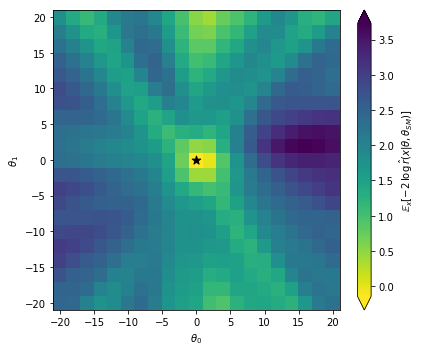

In [14]:
bin_size = theta_each[1] - theta_each[0]
edges = np.linspace(theta_each[0] - bin_size/2, theta_each[-1] + bin_size/2, len(theta_each)+1)

fig = plt.figure(figsize=(6,5))
ax = plt.gca()

expected_llr = np.mean(log_r_hat,axis=1)
best_fit = theta_grid[np.argmin(-2.*expected_llr)]

cmin, cmax = np.min(-2*expected_llr), np.max(-2*expected_llr)
    
pcm = ax.pcolormesh(edges, edges, -2. * expected_llr.reshape((21,21)),
                    norm=matplotlib.colors.Normalize(vmin=cmin, vmax=cmax),
                    cmap='viridis_r')
cbar = fig.colorbar(pcm, ax=ax, extend='both')

plt.scatter(best_fit[0], best_fit[1], s=80., color='black', marker='*')

plt.xlabel(r'$\theta_0$')
plt.ylabel(r'$\theta_1$')
cbar.set_label(r'$\mathbb{E}_x [ -2\, \log \,\hat{r}(x | \theta, \theta_{SM}) ]$')

plt.tight_layout()
plt.show()


Note that in this tutorial our sample size was very small, and the network might not really have a chance to converge to the correct likelihood ratio function. So don't worry if you find a minimum that is not at the right point (the SM, i.e. the origin in this plot). Feel free to dial up the event numbers in the run card as well as the training samples and see what happens then!

## 8. Limits

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import logging
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

from madminer.core import MadMiner
from madminer.lhe import LHEReader
from madminer.sampling import combine_and_shuffle
from madminer.sampling import SampleAugmenter
from madminer import sampling
from madminer.ml import ParameterizedRatioEstimator
from madminer.plotting import plot_2d_morphing_basis, plot_distributions
from madminer.limits import AsymptoticLimits


# MadMiner output
logging.basicConfig(
    format='%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s',
    datefmt='%H:%M',
    level=logging.INFO
)

# Output of all other modules (e.g. matplotlib)
for key in logging.Logger.manager.loggerDict:
    if "madminer" not in key:
        logging.getLogger(key).setLevel(logging.WARNING)

In the end, what we care about are not plots of the log likelihood ratio, but limits on parameters. But at least under some asymptotic assumptions, these are directly related. MadMiner makes it easy to calculate p-values in the asymptotic limit with the `AsymptoticLimits` class in the `madminer.limits`: 

In [2]:
limits = AsymptoticLimits('data/madminer_example_shuffled.h5')

11:47 madminer.limits      INFO    Loading data from data/madminer_example_shuffled.h5
11:47 madminer.limits      INFO    Found 2 parameters
11:47 madminer.limits      INFO    Found 6 benchmarks, of which 6 physical
11:47 madminer.limits      INFO    Found 2 observables: pt_j1, delta_phi_jj
11:47 madminer.limits      INFO    Found 6537 events
11:47 madminer.limits      INFO    Found morphing setup with 6 components


This class provids two high-level functions:
- `AsymptoticLimits.observed_limits()` lets us calculate p-values on a parameter grid for some observed events, and
- `AsymptoticLimits.expected_limits()` lets us calculate expected p-values on a parameter grid based on all data in the MadMiner file.

Note that these limits include both rate and kinematic information (the neural network is used for the kinematic part).

Let's try both:

In [3]:
theta_min, theta_max = -20., 20.
resolution = 51

### Expected limits with different analysis methods

In [4]:
_, p_values_expected_xsec, best_fit_expected_xsec = limits.expected_limits(
    theta_true=[0.,0.],
    theta_ranges=[(theta_min, theta_max), (theta_min, theta_max)],
    mode="rate",
    include_xsec=True,
    resolution=resolution,
    luminosity=300000.0
)

In [5]:
_, p_values_expected_histo, best_fit_expected_histo = limits.expected_limits(
    theta_true=[0.,0.],
    theta_ranges=[(theta_min, theta_max), (theta_min, theta_max)],
    mode="histo",
    hist_vars=["pt_j1"],
    include_xsec=False,
    resolution=resolution,
    luminosity=300000.0
)

11:47 madminer.limits      INFO    Building histogram with %s bins per parameter and %s bins per observable
11:47 madminer.sampling    INFO    Loading data from data/madminer_example_shuffled.h5
11:47 madminer.sampling    INFO    Found 2 parameters
11:47 madminer.sampling    INFO    Did not find nuisance parameters
11:47 madminer.sampling    INFO    Found 6 benchmarks, of which 6 physical
11:47 madminer.sampling    INFO    Found 2 observables
11:47 madminer.sampling    INFO    Found 6537 events
11:47 madminer.sampling    INFO    Found morphing setup with 6 components


11:47 madminer.sampling    INFO    Extracting plain training sample. Sampling according to ('thetas', [array([-20., -20.]), array([-19.2, -20. ]), array([-18.4, -20. ]), array([-17.6, -20. ]), array([-16.8, -20. ]), array([-16., -20.]), array([-15.2, -20. ]), array([-14.4, -20. ]), array([-13.6, -20. ]), array([-12.8, -20. ]), array([-12., -20.]), array([-11.2, -20. ]), array([-10.4, -20. ]), array([ -9.6, -20. ]), array([ -8.8, -20. ]), array([ -8., -20.]), array([ -7.2, -20. ]), array([ -6.4, -20. ]), array([ -5.6, -20. ]), array([ -4.8, -20. ]), array([ -4., -20.]), array([ -3.2, -20. ]), array([ -2.4, -20. ]), array([ -1.6, -20. ]), array([ -0.8, -20. ]), array([  0., -20.]), array([  0.8, -20. ]), array([  1.6, -20. ]), array([  2.4, -20. ]), array([  3.2, -20. ]), array([  4., -20.]), array([  4.8, -20. ]), array([  5.6, -20. ]), array([  6.4, -20. ]), array([  7.2, -20. ]), array([  8., -20.]), array([  8.8, -20. ]), array([  9.6, -20. ]), array([ 10.4, -20. ]), array([ 11.2, -2

11:47 madminer.sampling    WARNING Large statistical uncertainty on the total cross section for theta = [-20. -20.]: (0.005813 +/- 0.001110) pb. Skipping these warnings in the future...
11:47 madminer.sampling    WARNING For this value of theta, 1 / 5230 events have negative weight and will be ignored
11:47 madminer.sampling    WARNING For this value of theta, 1 / 5230 events have negative weight and will be ignored
11:47 madminer.sampling    WARNING For this value of theta, 1 / 5230 events have negative weight and will be ignored
11:47 madminer.sampling    WARNING Skipping warnings about negative weights in the future...
11:47 madminer.sampling    INFO    Effective number of samples: mean 17.960238334995925, with individual thetas ranging from 6.380937872443624 to 5230.000000000667
/Users/johannbrehmer/work/projects/madminer/madminer/madminer/utils/histo.py:198: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr

In [6]:
theta_grid, p_values_expected_ml, best_fit_expected_ml = limits.expected_limits(
    theta_true=[0.,0.],
    theta_ranges=[(theta_min, theta_max), (theta_min, theta_max)],
    mode="ml",
    model_file='models/alices',
    include_xsec=False,
    resolution=resolution,
    luminosity=300000.0
)

### Observed limits

In [7]:
sampler = SampleAugmenter('data/madminer_example_shuffled.h5')
x_observed, _ = sampler.extract_samples_test(
    theta=sampling.morphing_point([0.,0.]),
    n_samples=5,
    folder=None,
    filename=None
)

11:48 madminer.sampling    INFO    Loading data from data/madminer_example_shuffled.h5
11:48 madminer.sampling    INFO    Found 2 parameters
11:48 madminer.sampling    INFO    Did not find nuisance parameters
11:48 madminer.sampling    INFO    Found 6 benchmarks, of which 6 physical
11:48 madminer.sampling    INFO    Found 2 observables
11:48 madminer.sampling    INFO    Found 6537 events
11:48 madminer.sampling    INFO    Found morphing setup with 6 components
11:48 madminer.sampling    INFO    Extracting evaluation sample. Sampling according to ('theta', array([0., 0.]))
11:48 madminer.sampling    INFO    Effective number of samples: 1305.9999999999793


In [8]:
_, p_values_observed, best_fit_observed = limits.observed_limits(
    x_observed=x_observed,
    theta_ranges=[(theta_min, theta_max), (theta_min, theta_max)],
    mode="ml",
    model_file='models/alices',
    include_xsec=True,
    resolution=resolution,
    luminosity=300000.0,
)

### Plot

Let's plot the results:

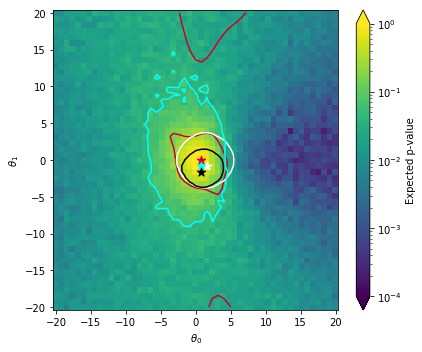

In [10]:
bin_size = (theta_max - theta_min)/(resolution - 1)
edges = np.linspace(theta_min - bin_size/2, theta_max + bin_size/2, resolution + 1)
centers = np.linspace(theta_min, theta_max, resolution)

fig = plt.figure(figsize=(6,5))
ax = plt.gca()

cmin, cmax = 1.e-4, 1.
    
pcm = ax.pcolormesh(
    edges, edges, p_values_expected_histo.reshape((resolution, resolution)),
    norm=matplotlib.colors.LogNorm(vmin=cmin, vmax=cmax),
    cmap='viridis'
)
cbar = fig.colorbar(pcm, ax=ax, extend='both')

plt.contour(
    centers, centers, p_values_expected_ml.reshape((resolution, resolution)),
    levels=[0.05],
    linestyles='-', colors='#CC002E'
)
plt.contour(
    centers, centers, p_values_expected_xsec.reshape((resolution, resolution)),
    levels=[0.05],
    linestyles='-', colors='white'
)
plt.contour(
    centers, centers, p_values_expected_histo.reshape((resolution, resolution)),
    levels=[0.05],
    linestyles='-', colors='cyan'
)
plt.contour(
    centers, centers, p_values_observed.reshape((resolution, resolution)),
    levels=[0.05],
    linestyles='-', colors='black'
)

plt.scatter(
    theta_grid[best_fit_expected_xsec][0], theta_grid[best_fit_expected_xsec][1],
    s=80., color='white', marker='*'
)
plt.scatter(
    theta_grid[best_fit_expected_ml][0], theta_grid[best_fit_expected_ml][1],
    s=80., color='#CC002E', marker='*'
)
plt.scatter(
    theta_grid[best_fit_expected_histo][0], theta_grid[best_fit_expected_histo][1],
    s=80., color='cyan', marker='*'
)
plt.scatter(
    theta_grid[best_fit_observed][0], theta_grid[best_fit_observed][1],
    s=80., color='black', marker='*'
)

plt.xlabel(r'$\theta_0$')
plt.ylabel(r'$\theta_1$')
cbar.set_label('Expected p-value')

plt.tight_layout()
plt.show()


That's it for now. Please have a look at the documentation for a detailed description of all classes and functions. And if you're curious about SALLY, Fisher information matrices, and ensemble methods, please look at the second part of the tutorial!